In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
from prettytable import PrettyTable

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [2]:
kanada_data = pd.read_csv("kn_train.csv")
kanada_val = pd.read_csv("kn_val.csv")
kanada_data = kanada_data[~((kanada_data["Word"] == "and") & (kanada_data["Tag"] == "sym"))].replace("*", "asterisk").fillna("")
kanada_val = kanada_val.replace("*", "asterisk").fillna("")

tamil_data = pd.read_csv("tamil_train.csv")
tamil_val = pd.read_csv("tamil_val.csv")
tamil_data = pd.concat([tamil_data, tamil_val], axis=0)

tulu_data = pd.read_csv("tulu_train.csv")
tulu_val = pd.read_csv("tulu_val.csv")
tulu_data = pd.concat([tulu_data, tulu_val], axis=0)

malayalam_data = pd.read_csv("mal_train.csv")
malayalam_val = pd.read_csv("mal_val.csv")
malayalam_data = pd.concat([malayalam_data, malayalam_val], axis=0)



# Oversampling "other", "mixed" and "kn" categories to improve accuracy of those categories
kanada_other = kanada_data[kanada_data["Tag"] == "other"]
kn = kanada_data[kanada_data["Tag"] == "kn"]
tulu_kn = tulu_data[tulu_data["Language"] == "Kannada"]
tulu_kn.columns = ["Word", "Tag"]
tulu_kn["Tag"] = tulu_kn["Tag"].replace("Kannada", "kn")
kn_mixed = kanada_data[kanada_data["Tag"] == "mixed"]

# Names from other languages are also included (More the data, Better the performance)
tamil_name = tamil_data[tamil_data["Tag"] == "name"]
kanada_name = kanada_data[kanada_data["Tag"] == "name"]
tulu_name = tulu_data[tulu_data["Language"] == "Name"]
tulu_name.columns = ["Word", "Tag"]
tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
malayalam_name = malayalam_data[malayalam_data["Tag"] == "NAME"]
malayalam_name["Tag"] = malayalam_name["Tag"].replace("NAME", "name")

# Locations from other languages are also included
tamil_loc = tamil_data[tamil_data["Tag"] == "Location"]
tamil_loc["Tag"] = tamil_loc["Tag"].replace("Location", "location")
kanada_loc = kanada_data[kanada_data["Tag"] == "location"]
tulu_loc = tulu_data[tulu_data["Language"] == "Location"]
tulu_loc.columns = ["Word", "Tag"]
tulu_loc["Tag"] = tulu_loc["Tag"].replace("Location", "location")
malayalam_loc = malayalam_data[malayalam_data["Tag"] == "PLACE"]
malayalam_loc["Tag"] = malayalam_loc["Tag"].replace("PLACE", "location")

# Combining all the data needed for training
kanada_data = pd.concat([kanada_data, tulu_kn, kanada_loc, kanada_name, tulu_name, kn_mixed, tamil_name, kanada_other, tulu_loc, kn, tamil_loc, malayalam_loc, kn_mixed, malayalam_name]).fillna("")
kanada_data_with_val = pd.concat([kanada_data, kanada_val])

C:\Users\justa\AppData\Local\Temp\ipykernel_15656\4260817246.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tulu_kn["Tag"] = tulu_kn["Tag"].replace("Kannada", "kn")
C:\Users\justa\AppData\Local\Temp\ipykernel_15656\4260817246.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
C:\Users\justa\AppData\Local\Temp\ipykernel_15656\4260817246.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [3]:
kanada_data["Tag"].value_counts()

Tag
en          17668
kn          10469
name         7501
other        5146
sym          3729
mixed        3231
location      936
Name: count, dtype: int64

In [4]:
kanada_data_with_val["Tag"].value_counts()

Tag
en          18777
kn          11106
name         7659
other        5199
sym          4063
mixed        3411
location      949
Name: count, dtype: int64

In [5]:
kanada_data.describe()

,Word,Tag
count,48680,48680
unique,10069,7
top,asterisk,en
freq,3736,17668


In [6]:
kanada_val.describe()

,Word,Tag
count,2484,2484
unique,961,7
top,asterisk,en
freq,334,1109


<Axes: xlabel='Tag', ylabel='Count'>

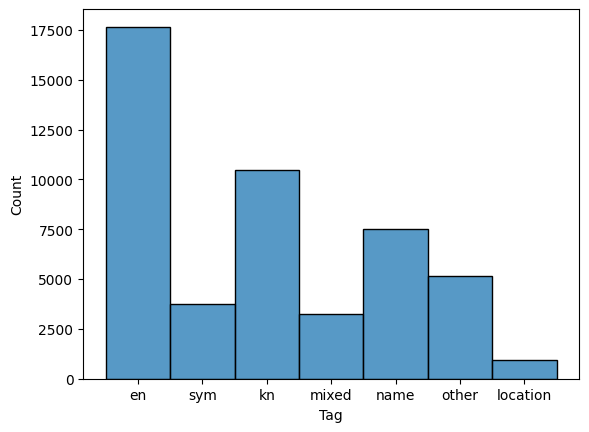

In [7]:
sb.histplot(kanada_data["Tag"])

In [8]:
countVectorizer = CountVectorizer(ngram_range=(1,5), analyzer='char')
tfidf = TfidfVectorizer(ngram_range=(1,5),analyzer='char')
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model1 = MultinomialNB()
model2 = MultinomialNB()

model3 = LogisticRegression(solver='newton-cg', max_iter=2000)
model4 = LogisticRegression(solver='newton-cg', max_iter=2000)

model5 = svm.SVC()
model6 = svm.SVC()

model8 = DecisionTreeClassifier(random_state=42)
model9 = DecisionTreeClassifier(random_state=42)

model7 = VotingClassifier(
    estimators=[
        ('dtc', model8), 
        ('lr', model3), 
        ('svm', model5),
    ],
    voting='hard'
)

acc = [[], [], [], [], [], [], [], []] 
f1 = [[], [], [], [], [], [], [], []]
pre = [[], [], [], [], [], [], [], []]
rec = [[], [], [], [], [], [], [], []]

f1_a = [[], [], [], [], [], [], [], []]

In [7]:
X = kanada_data_with_val["Word"]
Y = kanada_data_with_val["Tag"]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    

    train_vect_count = countVectorizer.fit_transform(X_train)
    test_vect_count = countVectorizer.transform(X_test)

    train_vect_tf = tfidf.fit_transform(X_train)
    test_vect_tf = tfidf.transform(X_test)


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
    model1.fit(train_vect_count, y_train)
    model1_predict = model1.predict(test_vect_count)

    acc[0].append(accuracy_score(y_test, model1_predict))
    f1[0].append(f1_score(y_test, model1_predict, average='macro'))
    f1_a[0].append(f1_score(y_test, model1_predict, average='weighted'))
    pre[0].append(precision_score(y_test, model1_predict, average='macro', zero_division=np.nan))
    rec[0].append(recall_score(y_test, model1_predict, average='macro', zero_division=np.nan))


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
    model2.fit(train_vect_tf, y_train)
    model2_predict = model2.predict(test_vect_tf)

    acc[1].append(accuracy_score(y_test, model2_predict))
    f1[1].append(f1_score(y_test, model2_predict, average='macro'))
    f1_a[1].append(f1_score(y_test, model2_predict, average='weighted'))
    pre[1].append(precision_score(y_test, model2_predict, average="macro", zero_division=np.nan))
    rec[1].append(recall_score(y_test, model2_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using COUNT VECTORIZATION
    model3.fit(train_vect_count, y_train)
    model3_predict = model3.predict(test_vect_count)

    acc[2].append(accuracy_score(y_test, model3_predict))
    f1[2].append(f1_score(y_test, model3_predict, average="macro"))
    f1_a[2].append(f1_score(y_test, model3_predict, average="weighted"))
    pre[2].append(precision_score(y_test, model3_predict, average="macro", zero_division=np.nan))
    rec[2].append(recall_score(y_test, model3_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using TFIDF VECTORIZATION
    model4.fit(train_vect_tf, y_train)
    model4_predict = model4.predict(test_vect_tf)

    acc[3].append(accuracy_score(y_test, model4_predict))
    f1[3].append(f1_score(y_test, model4_predict, average="macro"))
    f1_a[3].append(f1_score(y_test, model4_predict, average="weighted"))
    pre[3].append(precision_score(y_test, model4_predict, average="macro", zero_division=np.nan))
    rec[3].append(recall_score(y_test, model4_predict, average="macro", zero_division=np.nan))

    # SVM using COUNT VECTORIZATION
    model5.fit(train_vect_count, y_train)
    model5_predict = model5.predict(test_vect_count)

    acc[4].append(accuracy_score(y_test, model5_predict))
    f1[4].append(f1_score(y_test, model5_predict, average="macro"))
    f1_a[4].append(f1_score(y_test, model5_predict, average="weighted"))
    pre[4].append(precision_score(y_test, model5_predict, average="macro", zero_division=np.nan))
    rec[4].append(recall_score(y_test, model5_predict, average="macro", zero_division=np.nan))

    # SVM using TFIDF VECTORIZATION
    model6.fit(train_vect_tf, y_train)
    model6_predict = model6.predict(test_vect_tf)

    acc[5].append(accuracy_score(y_test, model6_predict))
    f1[5].append(f1_score(y_test, model6_predict, average="macro"))
    f1_a[5].append(f1_score(y_test, model6_predict, average="weighted"))
    pre[5].append(precision_score(y_test, model6_predict, average="macro", zero_division=np.nan))
    rec[5].append(recall_score(y_test, model6_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using COUNT VECTORIZATION
    model8.fit(train_vect_count, y_train)
    model8_predict = model8.predict(test_vect_count)

    acc[6].append(accuracy_score(y_test, model8_predict))
    f1[6].append(f1_score(y_test, model8_predict, average="macro"))
    f1_a[6].append(f1_score(y_test, model8_predict, average="weighted"))
    pre[6].append(precision_score(y_test, model8_predict, average="macro", zero_division=np.nan))
    rec[6].append(recall_score(y_test, model8_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using TFIDF VECTORIZATION
    model9.fit(train_vect_tf, y_train)
    model9_predict = model9.predict(test_vect_tf)

    acc[7].append(accuracy_score(y_test, model9_predict))
    f1[7].append(f1_score(y_test, model9_predict, average="macro"))
    f1_a[7].append(f1_score(y_test, model9_predict, average="weighted"))
    pre[7].append(precision_score(y_test, model9_predict, average="macro", zero_division=np.nan))
    rec[7].append(recall_score(y_test, model9_predict, average="macro", zero_division=np.nan))

In [8]:
MNB_count = ["MultinomialNB (Count)",sum(acc[0])/len(acc[0]), sum(f1[0])/len(f1[0]), sum(f1_a[0])/len(f1_a[0]),sum(pre[0])/len(pre[0]), sum(rec[0])/len(rec[0])]
MNB_tf = ["MultinomialNB (TFIDF)", sum(acc[1])/len(acc[1]), sum(f1[1])/len(f1[1]), sum(f1_a[1])/len(f1_a[1]), sum(pre[1])/len(pre[1]), sum(rec[1])/len(rec[1])]
Logistic_count = ["Logistic (Count)",sum(acc[2])/len(acc[2]), sum(f1[2])/len(f1[2]), sum(f1_a[2])/len(f1_a[2]), sum(pre[2])/len(pre[2]), sum(rec[2])/len(rec[2])]
Logistic_tf = ["Logistic (TFIDF)", sum(acc[3])/len(acc[3]), sum(f1[3])/len(f1[3]), sum(f1_a[3])/len(f1_a[3]), sum(pre[3])/len(pre[3]), sum(rec[3])/len(rec[3])]
SVM_count = ["SVM (Count)", sum(acc[4])/len(acc[4]), sum(f1[4])/len(f1[4]), sum(f1_a[4])/len(f1_a[4]), sum(pre[4])/len(pre[4]), sum(rec[4])/len(rec[4])]
SVM_tf = ["SVM (TFIDF)", sum(acc[5])/len(acc[5]), sum(f1[5])/len(f1[5]), sum(f1_a[5])/len(f1_a[5]), sum(pre[5])/len(pre[5]), sum(rec[5])/len(rec[5])]
DTC_count = ["DTC (Count)", sum(acc[6])/len(acc[6]), sum(f1[6])/len(f1[6]), sum(f1_a[6])/len(f1_a[6]), sum(pre[6])/len(pre[6]), sum(rec[6])/len(rec[6])]
DTC_tf = ["DTC (Count)", sum(acc[7])/len(acc[7]), sum(f1[7])/len(f1[7]), sum(f1_a[7])/len(f1_a[7]), sum(pre[7])/len(pre[7]), sum(rec[7])/len(rec[7])]

fields = ["Model Name", "Accuracy", "F1 Score (Macro)", "F1 Score (Weighted)", "Precision", "Recall Score"]

table = PrettyTable(field_names=fields)
table.add_rows([MNB_count, MNB_tf, Logistic_count, Logistic_tf, SVM_count, SVM_tf, DTC_count, DTC_tf])
table

Model Name,Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision,Recall Score
MultinomialNB (Count),0.8659994173860973,0.8563709661041663,0.8660353129254783,0.8577600514980471,0.8595486234875871
MultinomialNB (TFIDF),0.8739933484530784,0.8193427121424955,0.8683680875124766,0.9117779109152417,0.7780073300901339
Logistic (Count),0.9569422808852981,0.9487179611611957,0.9567154308907483,0.9538083765086247,0.9442826118080265
Logistic (TFIDF),0.9297356479184579,0.9098308156202328,0.9287073076697128,0.9373314262817279,0.8882026148038247
SVM (Count),0.9442966751585992,0.9342700546193473,0.9437257186988106,0.9491959027188578,0.9217167608851466
SVM (TFIDF),0.9572550939753321,0.9458562713865625,0.9569776311436604,0.9582549588744513,0.9354078846192333
DTC (Count),0.9479517446558964,0.9385748310926836,0.947841966466032,0.9402183794308193,0.9378796070566413
DTC (Count),0.9468375203964525,0.9381329665685765,0.9466556877013435,0.9410380706648921,0.9362433591154437


In [13]:
f1_a[2]

[0.9613653306995142,
 0.9572726186822931,
 0.9604812957685813,
 0.9530139299808998,
 0.9536041778961454,
 0.9555124366606097,
 0.9542024838672831,
 0.9599590165337315,
 0.9569222933371299,
 0.9548207254812947]

In [9]:
x_train = kanada_data["Word"]
y_train = kanada_data["Tag"]
x_test = kanada_val["Word"]
y_test = kanada_val["Tag"]

count_vec_train = countVectorizer.fit_transform(x_train)
tf_vec_train = tfidf.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)
tf_vec_test = tfidf.transform(x_test)

model7.fit(count_vec_train, y_train)
model7_predict = model7.predict(count_vec_test)

print(classification_report(y_test, model7_predict), "\n")

model7.fit(tf_vec_train, y_train)
model7_predict = model7.predict(tf_vec_test)

print(classification_report(y_test, model7_predict), "\n")

              precision    recall  f1-score   support

          en       0.97      0.99      0.98      1109
          kn       0.94      0.93      0.94       637
    location       1.00      0.46      0.63        13
       mixed       0.97      0.84      0.90       180
        name       0.83      0.98      0.90       158
       other       0.66      0.47      0.55        53
         sym       1.00      1.00      1.00       334

    accuracy                           0.95      2484
   macro avg       0.91      0.81      0.84      2484
weighted avg       0.95      0.95      0.95      2484
 

              precision    recall  f1-score   support

          en       0.96      0.99      0.97      1109
          kn       0.95      0.93      0.94       637
    location       1.00      0.46      0.63        13
       mixed       0.97      0.82      0.89       180
        name       0.84      0.97      0.90       158
       other       0.68      0.49      0.57        53
         sym       1.0

In [10]:
# result = pd.concat([x_test.reset_index(drop=True), pd.Series(model7_predict, name="Tag")], axis=1).replace("asterisk","*")
# result.to_csv('predictions.csv', index=False)

In [11]:
X_train = kanada_data["Word"]
y_train = kanada_data["Tag"]

X_test = kanada_val["Word"]
y_test = kanada_val["Tag"]

train_vect_count = countVectorizer.fit_transform(X_train)
test_vect_count = countVectorizer.transform(X_test)

train_vect_tf = tfidf.fit_transform(X_train)
test_vect_tf = tfidf.transform(X_test)


# MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
model1.fit(train_vect_count, y_train)
model1_predict = model1.predict(test_vect_count)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION")
print(classification_report(y_test, model1_predict), "\n\n")


# MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
model2.fit(train_vect_tf, y_train)
model2_predict = model2.predict(test_vect_tf)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION")
print(classification_report(y_test, model2_predict), "\n\n")


# LOGISTIC REGRESSION using COUNT VECTORIZATION
model3.fit(train_vect_count, y_train)
model3_predict = model3.predict(test_vect_count)
print("LOGISTIC REGRESSION using COUNT VECTORIZATION")
print(classification_report(y_test, model3_predict), "\n\n")


# LOGISTIC REGRESSION using TFIDF VECTORIZATION
model4.fit(train_vect_tf, y_train)
model4_predict = model4.predict(test_vect_tf)
print("LOGISTIC REGRESSION using TFIDF VECTORIZATION")
print(classification_report(y_test, model4_predict), "\n\n")

# SVM using COUNT VECTORIZATION
model5.fit(train_vect_count, y_train)
model5_predict = model5.predict(test_vect_count)
print("SVM using COUNT VECTORIZATION")
print(classification_report(y_test, model5_predict), "\n\n")

# SVM using TFIDF VECTORIZATION
model6.fit(train_vect_tf, y_train)
model6_predict = model6.predict(test_vect_tf)
print("SVM using TFIDF VECTORIZATION")
print(classification_report(y_test, model6_predict), "\n\n")

# Decision Tree Classifier using COUNT VECTORIZATION
model8.fit(train_vect_count, y_train)
model8_predict = model8.predict(test_vect_count)
print("Decision Tree Classifier using COUNT VECTORIZATION")
print(classification_report(y_test, model8_predict), "\n\n")

# Decision Tree Classifier using TFIDF VECTORIZATION
model9.fit(train_vect_tf, y_train)
model9_predict = model9.predict(test_vect_tf)
print("Decision Tree Classifier using TFIDF VECTORIZATION")
print(classification_report(y_test, model9_predict))

MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
              precision    recall  f1-score   support

          en       0.93      0.86      0.89      1109
          kn       0.87      0.86      0.87       637
    location       0.67      0.46      0.55        13
       mixed       0.65      0.84      0.73       180
        name       0.73      0.97      0.83       158
       other       0.30      0.25      0.27        53
         sym       1.00      1.00      1.00       334

    accuracy                           0.87      2484
   macro avg       0.73      0.75      0.73      2484
weighted avg       0.88      0.87      0.87      2484
 


MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
              precision    recall  f1-score   support

          en       0.91      0.97      0.94      1109
          kn       0.92      0.89      0.91       637
    location       0.00      0.00      0.00        13
       mixed       0.94      0.72      0.82       180

c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

LOGISTIC REGRESSION using COUNT VECTORIZATION
              precision    recall  f1-score   support

          en       0.97      0.99      0.98      1109
          kn       0.96      0.91      0.94       637
    location       1.00      0.54      0.70        13
       mixed       0.95      0.89      0.92       180
        name       0.80      0.97      0.88       158
       other       0.59      0.51      0.55        53
         sym       1.00      1.00      1.00       334

    accuracy                           0.95      2484
   macro avg       0.89      0.83      0.85      2484
weighted avg       0.95      0.95      0.95      2484
 


LOGISTIC REGRESSION using TFIDF VECTORIZATION
              precision    recall  f1-score   support

          en       0.95      0.99      0.97      1109
          kn       0.94      0.93      0.93       637
    location       0.86      0.46      0.60        13
       mixed       0.97      0.83      0.89       180
        name       0.83      0.97    